## Imports

In [1]:
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.callbacks import Callback, TensorBoard

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

### Settings

In [2]:
plt.style.use('ggplot')
pd.set_option('float_format', '{:,.2f}'.format)
%matplotlib inline
np.random.seed(42)

In [3]:
PROJECT_DIR = Path().cwd()

In [4]:
LANGUAGES = ['en', 'es']
language_dict = dict(zip(LANGUAGES, ['English', 'Spanish']))

## TED2013 Corpus Statistics

In [5]:
SOURCE = 'TED'
LANGUAGE = 'en'

In [6]:
with pd.HDFStore(Path('vocab', SOURCE, 'vocab.h5')) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: vocab/TED/vocab.h5
/en/ngrams            frame        (shape->[1758,4])   
/en/tokens            frame        (shape->[3130266,3])
/en/vocab             frame        (shape->[46176,1])  
/es/ngrams            frame        (shape->[1063,4])   
/es/tokens            frame        (shape->[2938546,3])
/es/vocab             frame        (shape->[74739,1])  
/stats                frame        (shape->[3,2])      


In [7]:
with pd.HDFStore(Path('vocab', SOURCE, 'vocab.h5')) as store:
    df = store['{}/vocab'.format(LANGUAGE)]

wc = df['count'].value_counts().sort_index(ascending=False).reset_index()
wc.columns = ['word_count', 'freq']
wc['n_words'] = wc.word_count.mul(wc.freq)

wc['corpus_share'] = wc.n_words.div(wc.n_words.sum())
wc['coverage'] = wc.corpus_share.cumsum()
wc['vocab_size'] = wc.freq.cumsum()

print('# words: {:,d}'.format(wc.n_words.sum()))
(wc
 .loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']]
 .head()
 .append(wc
         .loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']]
         .tail()))

# words: 2,710,455


,word_count,freq,n_words,vocab_size,coverage
0,127548,1,127548,1,0.05
1,90702,1,90702,2,0.08
2,74494,1,74494,3,0.11
3,70274,1,70274,4,0.13
4,64387,1,64387,5,0.16
893,5,1755,8775,17026,0.98
894,4,2484,9936,19510,0.98
895,3,3831,11493,23341,0.99
896,2,6822,13644,30163,0.99
897,1,16013,16013,46176,1.00


In [8]:
wc.word_count.div(wc.n_words.sum()).mul(100).describe(percentiles=[.5, .75, .95, .96, .97, .98, .99, .999])

count   898.00
mean      0.09
std       0.30
min       0.00
50%       0.02
75%       0.04
95%       0.31
96%       0.37
97%       0.49
98%       0.62
99%       1.63
99.9%     3.49
max       4.71
Name: word_count, dtype: float64

## Evaluation: Analogies

In [9]:
df = pd.read_csv(Path('data', 'analogies', 'analogies-en.txt'), header=None, names=['category'], squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [10]:
df = pd.concat([categories, analogies], axis=1)
df.category = df.category.ffill()
df = df[df['a'].notnull()]
df.head()

,category,a,b,c,d
1,: capital-common-countries,athens,greece,baghdad,iraq
2,: capital-common-countries,athens,greece,bangkok,thailand
3,: capital-common-countries,athens,greece,beijing,china
4,: capital-common-countries,athens,greece,berlin,germany
5,: capital-common-countries,athens,greece,bern,switzerland


In [11]:
analogy_cnt = df.groupby('category').size().sort_values(ascending=False).to_frame('n')
analogy_example = df.groupby('category').first()

In [12]:
analogy_cnt.join(analogy_example)

,n,a,b,c,d
category,,,,,
: capital-world,8556,abuja,nigeria,accra,ghana
: city-in-state,4242,chicago,illinois,houston,texas
: gram6-nationality-adjective,1640,albania,albanian,argentina,argentinean
: gram7-past-tense,1560,dancing,danced,decreasing,decreased
: gram8-plural,1332,banana,bananas,bird,birds
: gram3-comparative,1332,bad,worse,big,bigger
: gram4-superlative,1122,bad,worst,big,biggest
: gram5-present-participle,1056,code,coding,dance,dancing
: gram1-adjective-to-adverb,992,amazing,amazingly,apparent,apparently


## `word2vec` - skipgram Architecture using Keras

### Settings

In [13]:
NGRAMS = 3                                # Longest ngram in text
FILE_NAME = 'ngrams_{}'.format(NGRAMS)    # Input to use
MIN_FREQ = 5
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 5
EMBEDDING_SIZE = 200
EPOCHS = 1
BATCH_SIZE = 50

# Set up validation
VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)

In [14]:
path = Path('keras', SOURCE, LANGUAGE, FILE_NAME).resolve()
tb_path = path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

### Build Data Set

#### Tokens to ID

1. Extract the top *n* most common words to learn embeddings
2. Index these *n* words with unique integers
3. Create an `{index: word}` dictionary
4. Replace the *n* words with their index, and a dummy value `UNK` elsewhere

In [15]:
def build_data(language, ngrams=1):
    file_path = PROJECT_DIR / 'vocab' / SOURCE / language / 'ngrams_{}.txt'.format(ngrams)
    words = file_path.read_text().split()
    
    # Get (token, count) tuples for tokens meeting MIN_FREQ 
    token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
    tokens, counts = list(zip(*token_counts))
    
    # create id-token dicts & reverse dicts
    id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
    id_to_token.update({0: 'UNK'})
    token_to_id = {t:i for i, t in id_to_token.items()}
    data = [token_to_id.get(word, 0) for word in words]
    return data, token_to_id, id_to_token

In [16]:
data, token_to_id, id_to_token = build_data(LANGUAGE, ngrams=NGRAMS)

In [17]:
vocab_size = len(token_to_id)

In [18]:
vocab_size

31300

In [19]:
min(data), max(data)

(0, 31299)

In [20]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)

In [21]:
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,1,382644,the
1,2,272106,and
2,3,223482,to
3,4,210822,of
4,5,193161,a
5,6,169734,that
6,7,148863,i
7,8,142212,in
8,9,140793,it
9,10,132147,you


In [22]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

#### Analogies to ID

In [23]:
df = pd.read_csv(Path('data', 'analogies', 'analogies-{}.txt'.format(LANGUAGE)), 
                 header=None, squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [24]:
analogies.head()

,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [25]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.4546313799621928

### Generate Sampling Probabilities

There is an alternative, faster scheme than the traditional SoftMax loss function called [Noise Contrastive Estimation (NCE)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Instead of getting the softmax probability for all possible context words, randomly sample 2-20 possible context words and evaluate the probability only for these.

**SAMPLING_FACTOR**: used for generating the `sampling_table` argument for `skipgrams`. 

`sampling_table[i]` is the probability of sampling the word i-th most common word in a dataset

The sampling probabilities are generated according
to the sampling distribution used in word2vec:

$p(\text{word}) = \min(1, \frac{\sqrt{\frac{\text{word frequency}}{\text{sampling factor}}}}{\frac{\text{word frequency}}{\text{sampling factor}}}$

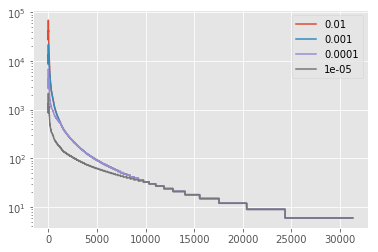

In [26]:
df = s['count'].to_frame('freq')
factors = [1e-2, 1e-3, 1e-4, 1e-5]
for f in factors:
    sf = make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)
df[factors].plot(logy=True);

In [27]:
sampling_table = make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR)

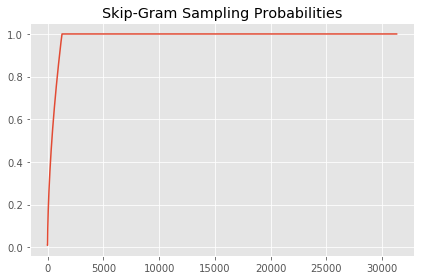

In [28]:
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

### Generate target-context word pairs

In [29]:
pairs, labels = skipgrams(sequence=data,
                            vocabulary_size=vocab_size,
                            window_size=WINDOW_SIZE,
                            sampling_table=sampling_table,
                            negative_samples=1.0,
                            shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

54,537,504 pairs created


In [30]:
pairs[:5]

[[14191, 19109], [38, 23254], [3158, 21317], [11976, 9158], [3945, 12059]]

In [31]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs

In [32]:
target_word[:5]

array([14191,    38,  3158, 11976,  3945], dtype=int32)

In [33]:
df = pd.DataFrame({'target': target_word[:5], 'context': context_word[:5], 'label': labels[:5]})
df

,context,label,target
0,19109,0,14191
1,23254,0,38
2,21317,0,3158
3,9158,0,11976
4,12059,0,3945


In [34]:
pd.Series(labels).value_counts()

1    27268752
0    27268752
dtype: int64

In [35]:
with pd.HDFStore(path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))

### Define Keras Model Components

#### Scalar Input Variables

In [36]:
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

#### Shared Embedding Layer

In [37]:
embedding = Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_SIZE,
                      input_length=1,
                      name='embedding_layer')

In [38]:
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target)

context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

#### Create Similarity Measure

In [39]:
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

#### Sigmoid Output Layer

In [40]:
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

#### Compile Training Model

In [41]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Display Architecture

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       6260000     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

#### Validation Model

In [46]:
similarity = Dot(normalize=True, 
                 axes=1, 
                 name='cosine_similarity')([target, context])

In [47]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)

In [48]:
validation_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       6260000     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

![Keras Graph](https://s3.amazonaws.com/applied-ai/images/keras_graph_tensorboard.png)

### Create Keras Callbacks

####  Nearest Neighors & Analogies

In [49]:
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

In [50]:
class EvalCallback(Callback):
        
    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))            
        
    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

#### Tensorboard Callback

In [51]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True,
                          embeddings_freq=1,
                          embeddings_metadata=str(tb_path / 'meta.tsv'))

### Train Model

In [52]:
loss = model.fit(x=[target_word, context_word],
                 y=labels,
                 shuffle=True,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[evaluation, tensorboard])

model.save(str(path / 'skipgram_model.h5'))

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



10 Nearest Neighbors:
've:	jd, tackling, dignity, ungulate, icing, instructions, kogi, rising, maneuverable, mapping
for:	lakes, freestyle, spectacularly, underpasses, anton, yorktown, rasselas, mallory, discovery, attire
kind:	spouses, systematically, documented, skins, hijab, astronaut, amen_amen, fragrance, understandably, 1990s
time:	showing, ivan, micronesia, loaf, salim, gang, carrel, liquid, discrete, charts
'm:	rasa, windshield_wiper, bin_ladenism, managing, crickets, destitute, shifted, redistributed, epiphanies, solicited
at:	nutshell, spoof, helped, dwarves, viagra, spill, closer, pooping, reforestation, beverly
had:	backseat, t1, cleared, epileptic, iib, cocktails, 1816, 3.50, leaps, iran_loves_israel
put:	symbolized, bashed, declassified, convulse, strogatz, tedmed, arendt, moog, baumgardner, aidg
your:	forehead, glibness, monochromatic, tunnel, priest, flippers, iced, belongs, marc, reputation
things:	update, curling, fullest, strangler, reagents, unum, doodle, mounting,

KeyboardInterrupt: 

## Optimized TensorFlow Model

Compile custom ops using `compile-ops.sh`.

Run from command line.

In [46]:
!ls tensorflow/

compile-ops.sh      word2vec.py         word2vec_ops.so.zip
run_tf.sh           word2vec_ops.so


In [49]:
# %%bash
# python tensorflow/word2vec.py --language=en --source=Ted --file=ngrams_1 --embedding_size=300 --num_neg_samples=20 --starter_lr=.1 --target_lr=.05 --batch_size=10 --min_count=10 --window_size=10

## word2vec using Gensim

### Evaluation

In [56]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

### Settings

In [57]:
ANALOGIES_PATH = PROJECT_DIR / 'data' / 'analogies' / 'analogies-{}.txt'.format(LANGUAGE)
gensim_path = PROJECT_DIR / 'gensim' / SOURCE / LANGUAGE / FILE_NAME
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

### Sentence Generator

In [53]:
sentence_path = PROJECT_DIR / 'vocab' / SOURCE / LANGUAGE / '{}.txt'.format(FILE_NAME)
sentences = LineSentence(str(sentence_path))

### Model

In [56]:
start = time()

model = Word2Vec(sentences,
                 sg=1,
                 size=300,
                 window=5,
                 min_count=10,
                 negative=10,
                 workers=8,
                 iter=20,
                 alpha=0.05)

model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration: {:,.1f}s'.format(time() - start))

# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH), case_insensitive=True)

# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

NameError: name 'gensim_path' is not defined

In [60]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,token,similarity
0,she,0.30
1,england,0.28
2,ace,0.27
3,heels,0.27
4,grandest,0.27
5,oedipus,0.26
6,accused,0.25
7,her,0.25
8,rented,0.25
9,thousand,0.25


In [61]:
similars = pd.DataFrame()
for id in valid_examples:
    word = id_to_token[id]
    similars[word] = [s[0] for s in model.wv.most_similar(id_to_token[id])]
    
similars.T

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,0,1,2,3,4,5,6,7,8,9
've,have,'d,’ve,been,had,got,has,'re,seen,scholarships
for,and,of,in,to,donnell_leahy,after,is,at,the,that
kind,sort,kinds,that,sense,dynamism,trite,type,reviewer,ding,a
time,moment,longtime,and,way,bar_mitzvah,photocopier,night,period,haas,christmas_eve
'm,am,i,'re,’m,gingerbread,was,want,optimist,myself,skeptic
at,in,fiddler,the,and,least,for,hockey_sticks,from,on,velociraptor
had,have,was,has,got,could,'ve,'d,were,kissed,would
put,putting,take,puts,go,zoom,slam,pull,brought,screamed,stents
your,my,you,their,our,his,her,cuz,yourself,its,the
things,ways,thing,places,mindsets,stuff,projects,that,attributes,modes,technologies


#### Continue Training

In [62]:
accuracies = [summary]
for i in range(1, 11):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH))
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print('{} | Duration: {:,.1f} | Accuracy: {:.2%} '.format(i, time() - start, accuracies[-1][-1]))

pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average']).to_csv(gensim_path / 'accuracies.csv', index=False)
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `accuracy` (Method will be removed in 4.0.0, use self.evaluate_word_analogies() instead).
  """
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


1 | Duration: 36.0 | Accuracy: 8.03% 
2 | Duration: 37.1 | Accuracy: 8.69% 
3 | Duration: 36.1 | Accuracy: 8.91% 
4 | Duration: 36.1 | Accuracy: 8.43% 
5 | Duration: 36.5 | Accuracy: 8.52% 
6 | Duration: 36.3 | Accuracy: 8.77% 
7 | Duration: 36.0 | Accuracy: 8.96% 
8 | Duration: 36.1 | Accuracy: 8.64% 
9 | Duration: 36.4 | Accuracy: 8.88% 
10 | Duration: 35.9 | Accuracy: 8.57% 


## The `google` command-line Tool

### Run from Command Line

In [ ]:
%%bash
file_name=../data/wiki/en/wiki.txt
time ./word2vec -train "$file_name" -output vectors_en.bin - cbow 1 -size 300  -min-count 10  -window 10 -negative 10 -hs 0 -sample 1e-4 -threads 8 -binary 1 -iter 1

### Load Trained Model & Word Vectors via `gensim`

In [32]:
file_name = 'word2vec/word_vectors/vectors_en.bin'
model = KeyedVectors.load_word2vec_format(file_name, binary=True, unicode_errors='ignore')

In [33]:
vectors = model.vectors[:100000]
vectors /= norm(vectors, axis=1).reshape(-1, 1)
vectors.shape

(100000, 300)

In [34]:
words = model.index2word[:100000]
word2id = {w:i for i, w in enumerate(words)}

### Compute Accuracy

In [37]:
analogy_path = PROJECT_DIR / 'data/analogies/analogies-en.txt'
accuracy = model.accuracy(questions=str(analogy_path), restrict_vocab=100000)

In [38]:
summary = accuracy_by_category(accuracy, detail=True)
print('\nOverall Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      459         47     0.91
7             gram3-comparative     1207        125     0.91
10  gram6-nationality-adjective     1472        168     0.90
4                        family      438         68     0.87
1                 capital-world     7058       1132     0.86
12                 gram8-plural     1082        250     0.81
14                        total    17974       6458     0.74
11             gram7-past-tense     1118        442     0.72
9      gram5-present-participle      726        330     0.69
13           gram9-plural-verbs      580        290     0.67
2                 city-in-state     2601       1641     0.61
8             gram4-superlative      605        387     0.61
6                gram2-opposite      254        502     0.34
5     gram1-adjective-to-adverb      312        680     0.31
3                      currency       62        396     0.14

Overall Accuracy: Corre

### Project Data using `tensorboard` Projector

In [66]:
PROJECTION_LIMIT = 10000
proj_path = Path('word2vec', 'projector')
pd.Series(words).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'meta_data.tsv', index=False, header=None, sep='\t')
pd.DataFrame(vectors).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'embeddings.tsv', index=False, header=None, sep='\t')

### Project Analogies

#### Incremental PCA

In [35]:
pca = IncrementalPCA(n_components=2)

vectors2D = pca.fit_transform(vectors)
pd.Series(pca.explained_variance_ratio_).mul(100)

0   3.69
1   3.19
dtype: float64

#### Group Analogies by Category

In [39]:
results = pd.DataFrame()
correct = incorrect = 0
for section in accuracy:
    correct += len(section['correct'])
    incorrect += len(section['incorrect'])
    df = pd.DataFrame(section['correct']).apply(lambda x: x.str.lower()).assign(section=section['section'])
    results = pd.concat([results, df])

#### Identify Analogy most similar in 2D

In [41]:
def find_most_similar_analogy(v):
    """Find analogy that most similar in 2D"""
    v1 = vectors2D[v[1]] - vectors2D[v[0]]
    v2 = vectors2D[v[3]] - vectors2D[v[2]]
    idx, most_similar = None, np.inf
    
    for i in range(len(v1)):
        similarity = cosine(v1[i], v2[i])
        if similarity < most_similar:
            idx = i
            most_similar = similarity
    return idx

In [42]:
def get_plot_lims(coordinates):
    xlim, ylim = coordinates.agg(['min', 'max']).T.values
    xrange, yrange = (xlim[1] - xlim[0]) * .1, (ylim[1] - ylim[0]) * .1
    xlim[0], xlim[1] = xlim[0] - xrange, xlim[1] + xrange
    ylim[0], ylim[1] = ylim[0] - yrange, ylim[1] + yrange
    return xlim, ylim

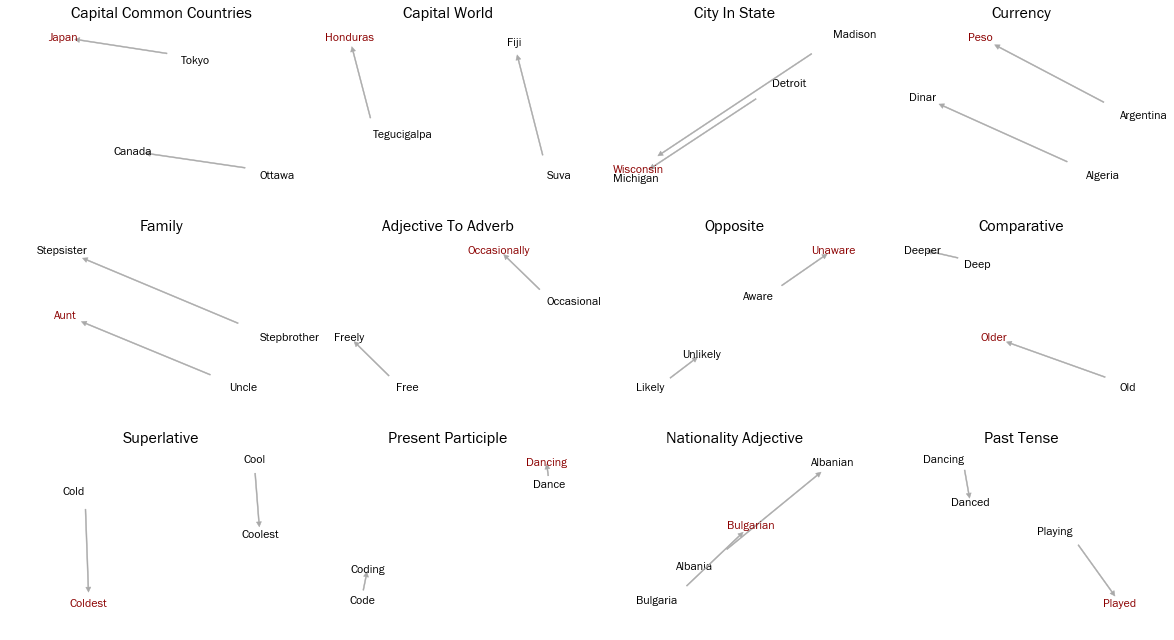

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flatten()
fc = ec = 'darkgrey'
for s, (section, result) in enumerate(results.groupby('section')):
    if s > 11:
        continue
        
    df = result.drop('section', axis=1).apply(lambda x: x.map(word2id))
    most_similar_idx = find_most_similar_analogy(df)
    
    best_analogy = result.iloc[most_similar_idx, :4].tolist()

    analogy_idx = [words.index(word) for word in best_analogy]
    best_analogy = [a.capitalize() for a in best_analogy]
    
    coords = pd.DataFrame(vectors2D[analogy_idx])  # xy array
    
    xlim, ylim = get_plot_lims(coords)
    axes[s].set_xlim(xlim)
    axes[s].set_ylim(ylim)

    for i in [0, 2]:
        axes[s].annotate(s=best_analogy[i], xy=coords.iloc[i+1], xytext=coords.iloc[i],
                         arrowprops=dict(width=1,headwidth=5, headlength=5,
                                         fc=fc, ec=ec, shrink=.1),
                         fontsize=12)
    
        axes[s].annotate(best_analogy[i+1], xy=coords.iloc[i+1],
                         xytext=coords.iloc[i+1],
                         va='center', ha='center',
                         fontsize=12, color='darkred' if i == 2 else 'k');

    axes[s].axis('off')
    title = ' '.join([s.capitalize()
                      for s in section.split('-') if not s.startswith('gram')])
    axes[s].set_title(title, fontsize=16)

fig.tight_layout();

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)